In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

Wczytanie i podział danych

In [3]:
data = pd.read_csv(r"C:\Users\Rafal\OneDrive\Dokumenty\GitHub\Komputerowa-analiza-szeregow-czasowych\rainfall-monthly-total.csv")
month = data['month']
time = np.arange(0,len(month),1)
rainfalls = data['total_rainfall'] 

Wizualizacja

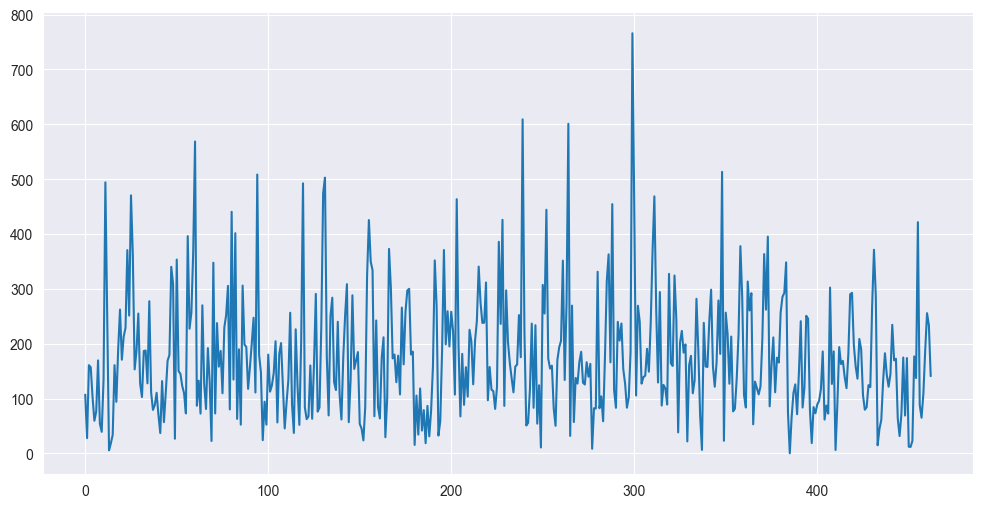

In [12]:
plt.figure(figsize=(12,6))
plt.plot(time, rainfalls)
plt.show()

Sprawdzenie, czy są puste rekordy

In [13]:
data_info = data.info()
data_head = data.head()
data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   month           463 non-null    object 
 1   total_rainfall  463 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.4+ KB


(None,
      month  total_rainfall
 0  1982-01           107.1
 1  1982-02            27.8
 2  1982-03           160.8
 3  1982-04           157.0
 4  1982-05           102.2)

Obserwacje odstające, statystyki opisowe dla zmiennej rainfalls

In [14]:
rainfall_stats = data['total_rainfall'].describe()

Q1 = data['total_rainfall'].quantile(0.25)
Q3 = data['total_rainfall'].quantile(0.75)
IQR = Q3 - Q1
outlier_thresholds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
outliers = data[(data['total_rainfall'] < outlier_thresholds[0]) | 
                (data['total_rainfall'] > outlier_thresholds[1])]

rainfall_stats, outliers

(count    463.000000
 mean     176.160043
 std      113.186092
 min        0.200000
 25%       89.050000
 50%      158.400000
 75%      237.900000
 max      765.900000
 Name: total_rainfall, dtype: float64,
        month  total_rainfall
 11   1982-12           494.1
 25   1984-02           470.4
 60   1987-01           568.6
 94   1989-11           508.4
 119  1991-12           492.3
 130  1992-11           474.3
 131  1992-12           502.7
 203  1998-12           463.4
 239  2001-12           609.0
 264  2004-01           600.9
 299  2006-12           765.9
 311  2007-12           468.6
 348  2011-01           513.2)

Sprawdzenie ciągłości miesięcy 

In [15]:
for i in range(1, len(month)):
    m_present = int(month[i][-2:])
    y_present = int(month[i][:4])
    m_previous = int(month[i-1][-2:])
    y_previous = int(month[i-1][:4])
    if m_present != m_previous + 1:
        if m_present == m_previous - 11:
            if y_present != y_previous + 1:
                print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
                break
        else:
            print(f"Występuje brak ciągłości miesięcy między: {month[i-1]} a {month[i]}")
            break
    if i == len(month)-1:
        print("W miesiącach nie brakuje danych, ciąłość jest zachowana")


W miesiącach nie brakuje danych, ciąłość jest zachowana


Przygotowanie zbioru testowego i treningowego

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

ACF i PACF

In [18]:
h_max = 40

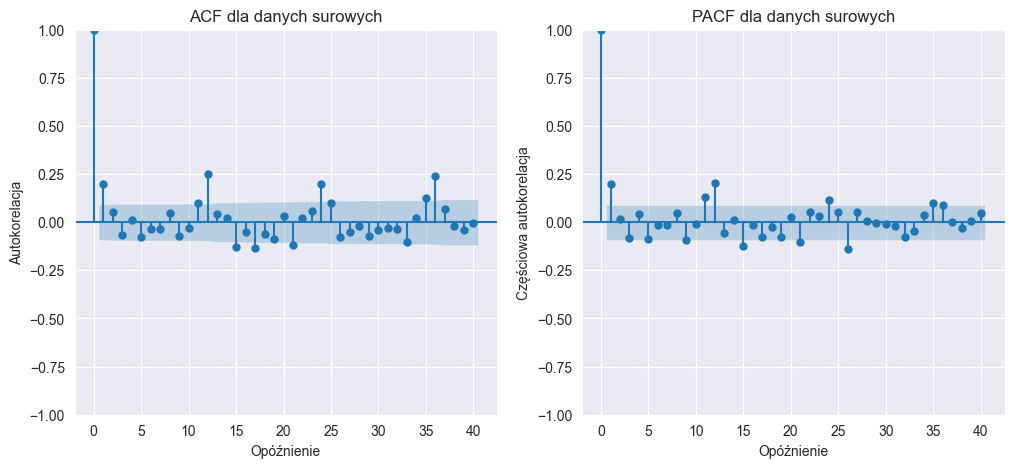

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(rainfalls, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(122)
plot_pacf(rainfalls, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.show()

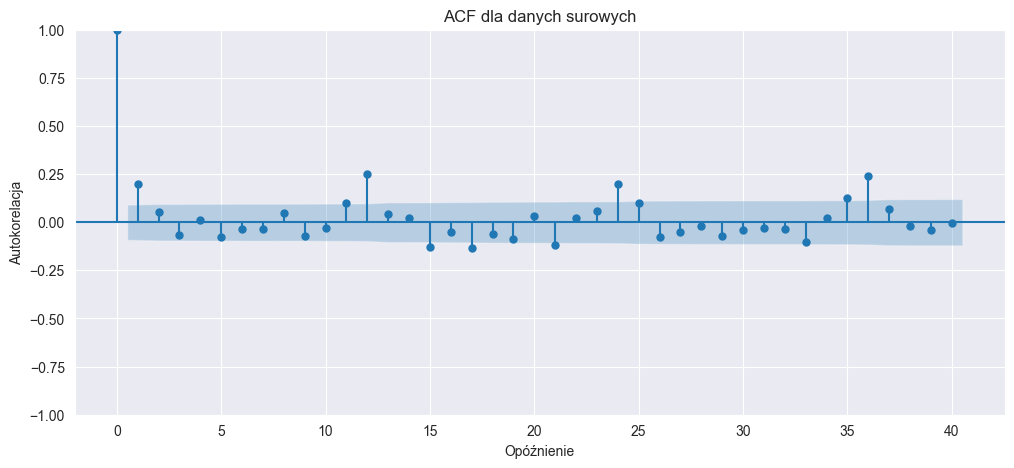

In [20]:
plt.figure(figsize=(12, 5))
plot_acf(rainfalls, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')
plt.show()


Okres wynosi około 12

Test stacjonarności - Augmented Dickey-Fuller Test

In [84]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [85]:
adfuller_test(rainfalls)

Statystyka testowa = -5.325, p-Value = 0.0 => Stationary. 


Dekompozycja

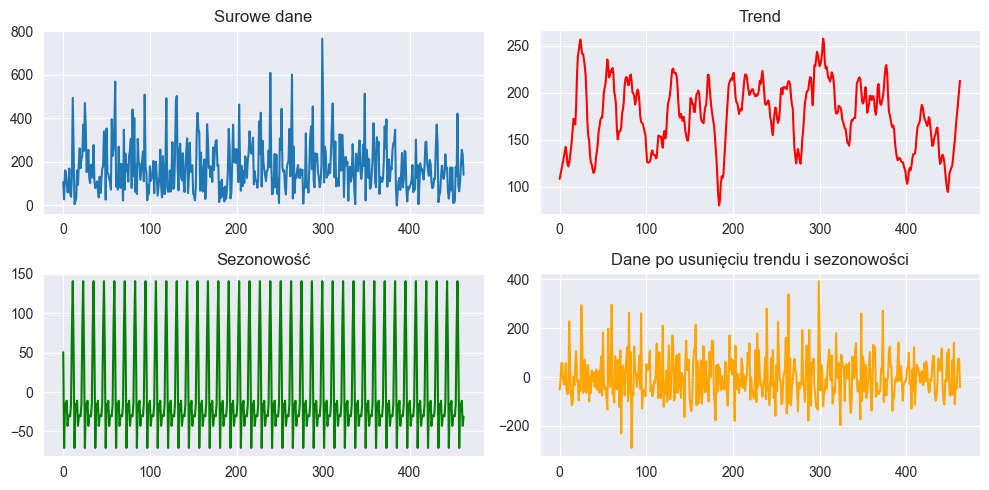

In [7]:
decomposition = seasonal_decompose(rainfalls, model='additive', period=12, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(rainfalls, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [8]:
mae_residual = np.mean(np.abs(rainfalls - residual))
print(f"Mean Absolute Error: {mae_residual}")

Mean Absolute Error: 176.21184280105768


In [9]:
rainfalls_clean = residual

Sprawdzenie stacjonarności dla danych wyczyszczonych

In [92]:
adfuller_test(rainfalls_clean)

Statystyka testowa = -9.757, p-Value = 0.0 => Stationary. 


ACF i PACF dla wyczyszczonych danych

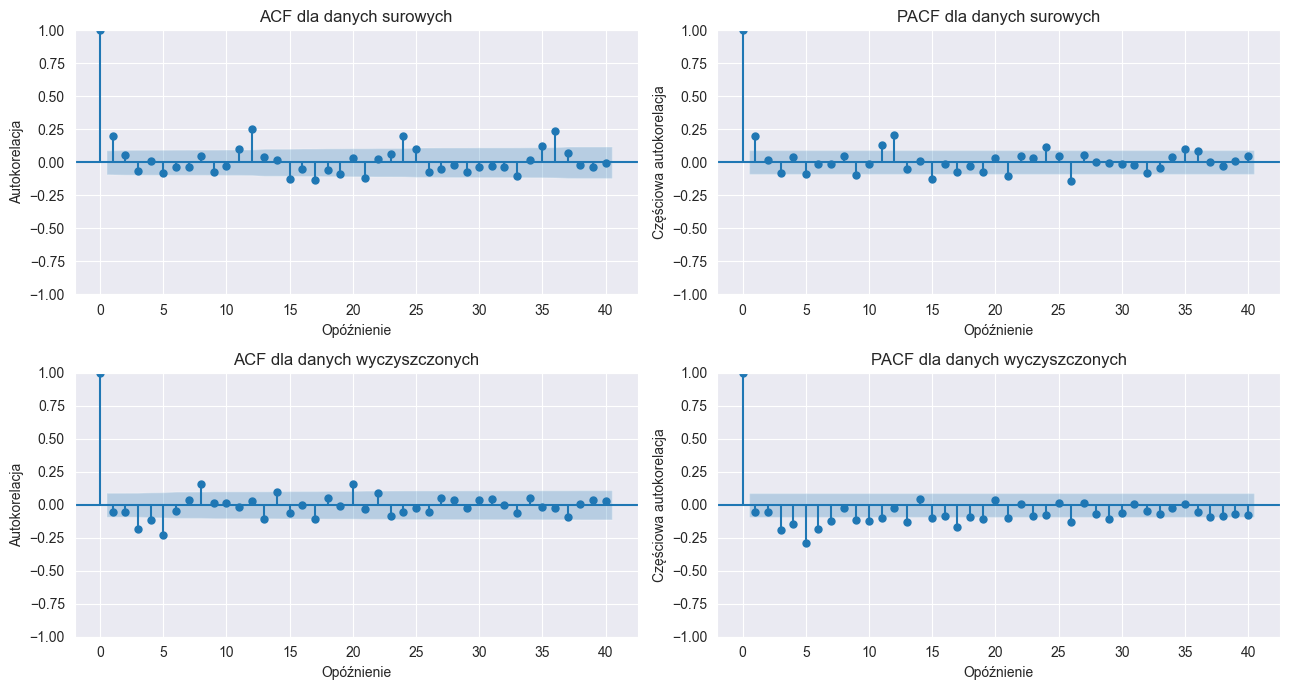

In [104]:
plt.figure(figsize=(13,7))

plt.subplot(223)
plot_acf(rainfalls_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych wyczyszczonych')

plt.subplot(224)
plot_pacf(rainfalls_clean, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych wyczyszczonych')

plt.subplot(221)
plot_acf(rainfalls, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla danych surowych')

plt.subplot(222)
plot_pacf(rainfalls, lags=h_max, ax=plt.gca())
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla danych surowych')

plt.tight_layout()
plt.show()

Dopasowanie modelu

In [109]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 5
max_q = 5

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(rainfalls_clean, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

c:\Users\Rafal\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Rafal\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Rafal\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Rafal\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

In [110]:
df.sort_values(by='AIC').head(1)

,p,q,AIC,BIC,HQIC
19,3,4,5340.219232,5377.458775,5354.879412


In [111]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
19,3,4,5340.219232,5377.458775,5354.879412


In [112]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
19,3,4,5340.219232,5377.458775,5354.879412


In [113]:
model3 = pm.auto_arima(rainfalls_clean, 
                       d=0,
                       start_p=0,
                       start_q=0,
                       max_d=0,
                       max_p=5, 
                       max_q=5, 
                       max_order=None,
                       trace=True, 
                       seasonal=False, 
                       stepwise = False)

print(model3.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5489.697, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5489.898, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5490.145, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5490.642, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARI

Estymacja parametrów

In [10]:
p, q = 3, 4

model = ARIMA(rainfalls_clean, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  463
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -2660.183
Date:                Sun, 19 Jan 2025   AIC                           5338.366
Time:                        13:26:08   BIC                           5375.606
Sample:                             0   HQIC                          5353.026
                                - 463                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.040      0.238      0.812      -0.070       0.089
ar.L1          0.5180      0.065      8.015      0.000       0.391       0.645
ar.L2          0.8350      0.052     16.075 